# Проект модуля. Нейросеть для предсказания калорийности блюд

**Задача:** создать и обучить нейросеть, которая будет предсказывать калорийность блюд.

**Целевая метрика:** Модель будет считаться готовой к интеграции в продукт при точности оценки MAE < 50 (MAE — Mean Absolute Error) на тестовой выборке.

**Датасет:** фотографии блюд, описание ингредиентов, общая масса порции и калорийность

`data/ingredients.csv`
* `id` — ID ингредиента
* `ingr` — название ингредиента

`data/dish.csv`
* `dish_id` — ID блюда
* `total_calories` — общее число калорий. Это целевая переменная
* `total_mass` — масса блюда
* `ingredients` — список всех ID ингредиентов в формате ingr_0000000122;ingr_0000000026;.., где ненулевая часть соответствует ID ингредиента из data/ingredients.csv
* `split` — метка, указывающая, куда отнести блюдо: train/test. Эта метка поможет разделить датасет при тренировке

`data/images` — датасет с фотографиями блюд, каждая директория соответствует dish_id из data/dish.csv и содержит rgb.png фото блюда.

## 1. Исследовательский анализ (EDA)

### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
from pathlib import Path
import sys
import torch
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_palette("husl")
from scripts.utils import train
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scripts.utils import load_model
from scripts.dataset import create_dataloaders

### 1.2 Загрузка данных

In [2]:
# Ингредиенты
ingredients_df = pd.read_csv('data/ingredients.csv')

In [3]:
# Блюда
dish_df = pd.read_csv('data/dish.csv')

### 1.3 Обзор данных

Изучим датасет с ингредиентами

In [4]:
ingredients_df

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes
...,...,...
550,551,pizza sauce
551,552,pomegranate
552,553,nut cheese
553,554,soy sausage


In [5]:
ingredients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


В датафрейме 2 колонки и 555 строк. Типы данных не нарушены.

In [6]:
ingredients_df.nunique()

id      555
ingr    552
dtype: int64

В данных 555 уникальных id, но 552 уникальных ингредиента. 

In [7]:
ingredients_df.groupby("ingr")["id"].nunique().sort_values(ascending=False).head(5)


ingr
deprecated    4
lemon         1
pecans        1
pepper        1
pepperoni     1
Name: id, dtype: int64

Ингредиент deprecated, не имеющий подходящего к контексту перевода, повторяется 4 раза. Дубликатами в данном случае это считать нельзя, потому что разные айди соответствуют айди в датасете dish_df, удалять нельзя

In [8]:
# Изучим ингредиент 

deprecated = (
    ingredients_df.groupby("ingr")["id"]
      .nunique()
      .sort_values(ascending=False)
      .idxmax()
)

ingredients_df.loc[ingredients_df["ingr"] == deprecated, "id"].unique()



array([231, 453, 458, 470])

In [9]:
bad_ids = [231, 453, 458, 470]
bad_tokens = [f'ingr_{i:010d}' for i in bad_ids]

mask = dish_df["ingredients"].apply(
    lambda x: any(token in x for token in bad_tokens)
)

result = dish_df[mask]
result


,dish_id,total_calories,total_mass,ingredients,split
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train
55,dish_1558114086,74.360001,143.0,ingr_0000000453,test
123,dish_1558027001,20.400002,68.0,ingr_0000000458,train
334,dish_1558373159,1013.337036,334.0,ingr_0000000039;ingr_0000000453;ingr_0000000077,test
594,dish_1558115364,485.260010,313.0,ingr_0000000005;ingr_0000000453;ingr_000000007...,train
701,dish_1558114875,74.360001,143.0,ingr_0000000453,train
749,dish_1558375506,73.839996,142.0,ingr_0000000453,train
908,dish_1558028142,21.900002,73.0,ingr_0000000458,train
1025,dish_1558031019,206.442001,197.0,ingr_0000000192;ingr_0000000004;ingr_000000045...,train
1068,dish_1558030724,18.300001,61.0,ingr_0000000458,train


Есть блюда, состоящие только из этого ингредиента. Выведем изображения.

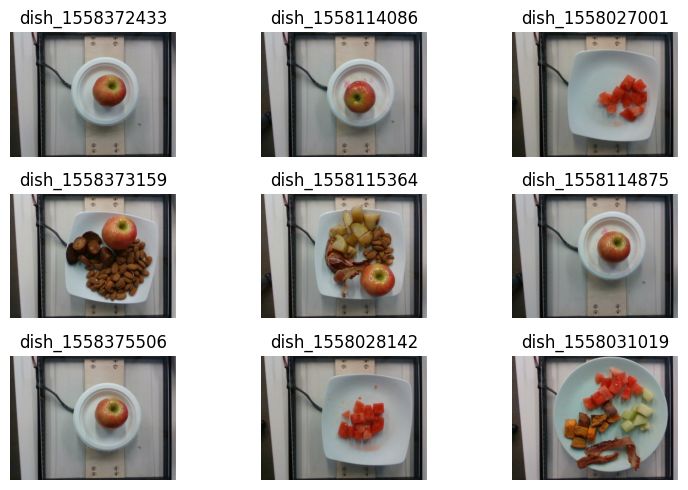

In [10]:
dish_ids = result["dish_id"].unique()

image_paths = [
    Path("data/images") / dish_id / "rgb.png"
    for dish_id in dish_ids
]

existing_images = [p for p in image_paths if p.exists()]
missing_images = [p for p in image_paths if not p.exists()]

images_to_show = existing_images[:9]

rows = 3
cols = 3

plt.figure(figsize=(8, 5))

for i, path in enumerate(images_to_show):
    img = Image.open(path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(path.parent.name)
    plt.axis("off")

plt.tight_layout()
plt.show()


Без дополнительной информации невозможно сделать достоверные выводы о корректности заполения данных с этим ингредиентом. Оставим без изменений

Изучим датасет с блюдами

In [11]:
dish_df

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train
...,...,...,...,...,...
3257,dish_1563295334,228.540009,96.0,ingr_0000000004;ingr_0000000008,train
3258,dish_1566329234,262.625214,457.0,ingr_0000000161;ingr_0000000189;ingr_000000000...,train
3259,dish_1562691737,485.676880,700.0,ingr_0000000543;ingr_0000000027;ingr_000000012...,train
3260,dish_1558458496,53.130001,77.0,ingr_0000000440,train


In [12]:
dish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB


В датасете 5 колонок и 3262 строк. Типы данных не нарушены.

In [13]:
# Выведем уникальные значения в столбцах 
dish_df.nunique()

dish_id           3262
total_calories    3014
total_mass         608
ingredients       2294
split                2
dtype: int64

### 1.4 Проверка на пропущенные значения

In [14]:
print("Пропущенные значения в dish.csv:")
print(dish_df.isnull().sum())
print("\nПропущенные значения в ingredients.csv:")
print(ingredients_df.isnull().sum())

Пропущенные значения в dish.csv:
dish_id           0
total_calories    0
total_mass        0
ingredients       0
split             0
dtype: int64

Пропущенные значения в ingredients.csv:
id      0
ingr    0
dtype: int64


Пропусков нет.

### 1.5 Распределение данных по train/test

Распределение данных:
split
train    2755
test      507
Name: count, dtype: int64


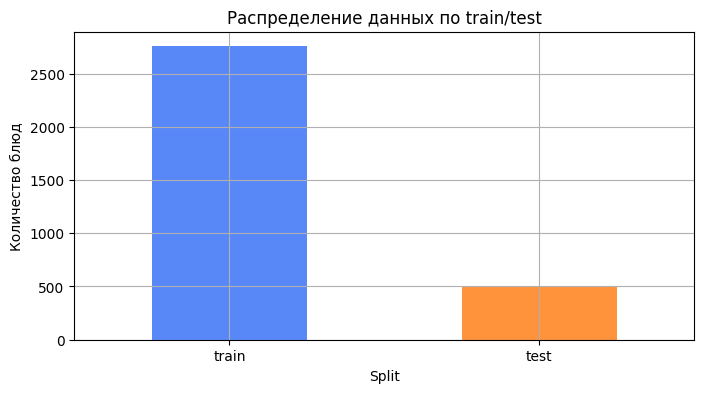

In [15]:
split_counts = dish_df['split'].value_counts()
print('Распределение данных:')
print(split_counts)

plt.figure(figsize=(8, 4))
split_counts.plot(kind='bar', color=["#5887f7", "#fe933b"])
plt.title('Распределение данных по train/test')
plt.xlabel('Split')
plt.ylabel('Количество блюд')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

В train 2755 блюда, в test - 507

### 1.6 Анализ калорийности

In [16]:
round(dish_df['total_calories'].describe(), 2)

count    3262.00
mean      255.01
std       219.64
min         0.00
25%        80.11
50%       209.11
75%       375.12
max      3943.33
Name: total_calories, dtype: float64

Всего в датасете 3262 блюда. Минимальная калорийность - 0, максимальная - 3943.33. Среднее значение 255, а медианное - 209, что свидетельствует о наличии выбросов. 75% блюд в датасете имеют калорийность до 375 кк.

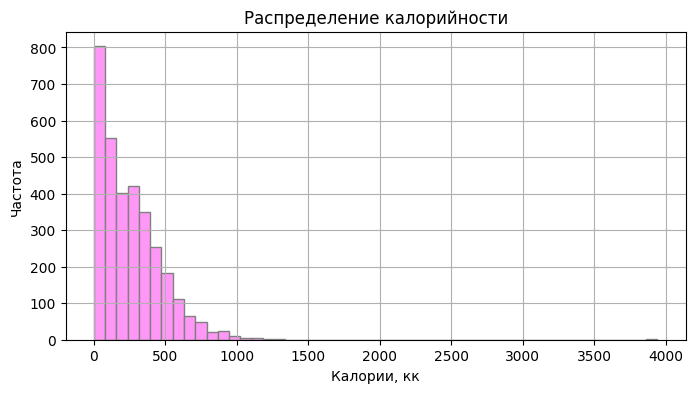

In [17]:
plt.figure(figsize=(8, 4))
plt.hist(dish_df['total_calories'], bins=50, edgecolor='grey', color="#ff97f6")
plt.title('Распределение калорийности')
plt.xlabel('Калории, кк')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


Посмотрим на выбросы

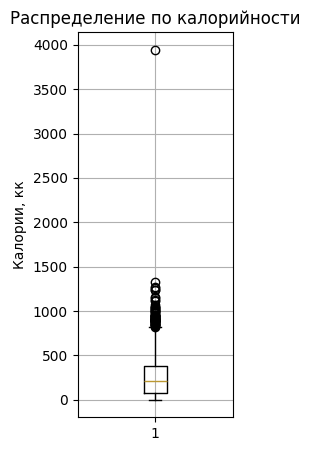

In [18]:
# Распределение по калорийности
plt.figure(figsize=(2, 5))
plt.boxplot(dish_df['total_calories'])
plt.title('Распределение по калорийности')
plt.ylabel('Калории, кк')
plt.grid(True)
plt.show()

Изучим распределение калорийности по train/test

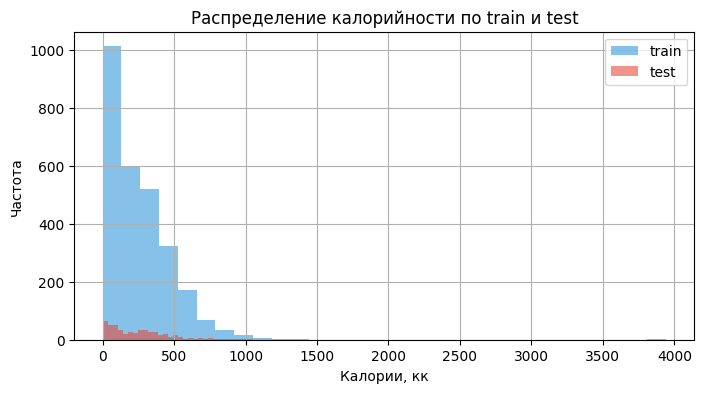

In [45]:
# train/test
train_cal = dish_df[dish_df['split'] == 'train']['total_calories']
test_cal = dish_df[dish_df['split'] == 'test']['total_calories']

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(train_cal, bins=30, alpha=0.6, label='train', color='#3498db')
ax.hist(test_cal, bins=30, alpha=0.6, label='test', color='#e74c3c')
ax.set_title('Распределение калорийности по train и test')
ax.set_xlabel('Калории, кк')
ax.set_ylabel('Частота')
ax.legend()
ax.grid(True)

plt.show()


В train намного больше данных, однако распределение по калорийности примерно пропорционально.

Блюдо с максимальным количеством калорий: dish_1560974769
Калории: 3943.33 кк
Масса: 3051.0 г
Ингредиенты:
  - cantaloupe
  - broth
  - ham
  - nuts
  - broccoli
  - couscous
  - donuts
  - bell peppers
  - pork chops
  - crawfish
  - spreads
  - jerky
  - artichokes
  - water


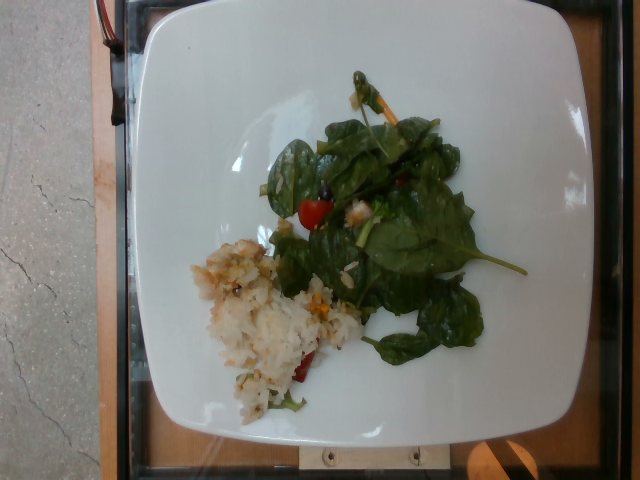

In [20]:
# Отобразим блюдо с самой высокой колорийностью
image_dir = 'data/images'

max_calorie_dish = dish_df.loc[dish_df['total_calories'].idxmax()] 
dish_id = max_calorie_dish['dish_id'] # Извлекаем ID самого калорийного блюда
total_calories = round(max_calorie_dish['total_calories'], 2) # Извлекаем общее количество калорий этого блюда
total_mass = max_calorie_dish['total_mass'] # Извлекаем общую массу блюда в граммах

ingredients_list = max_calorie_dish['ingredients'].split(';') # Получаем строку с ID ингредиентов 

ingr_names = []
for ingr_id in ingredients_list:
    # Извлекаем номер ингредиента
    id_num = ingr_id.split('_')[1]
    id_num_int = int(id_num)
    ingr_row = ingredients_df[ingredients_df['id'] -1  == id_num_int]
    if not ingr_row.empty:
        ingr_names.append(ingr_row['ingr'].values[0])

# Вывод информации
print(f'Блюдо с максимальным количеством калорий: {dish_id}')
print(f'Калории: {total_calories} кк')
print(f'Масса: {total_mass} г')
print('Ингредиенты:')
for name in ingr_names:
    print(f"  - {name}")

# Путь к изображению
image_path = f'data/images/{dish_id}/rgb.png'
if os.path.exists(image_path):
    img = Image.open(image_path)
    display(img)
else:
    print(f"Фото не найдено: {image_path}")


In [21]:
min_calorie_dish = dish_df.loc[dish_df['total_calories'].idxmin()] 
dish_id = min_calorie_dish['dish_id'] # Извлекаем ID самого калорийного блюда
total_calories = round(min_calorie_dish['total_calories'], 2) # Извлекаем общее количество калорий этого блюда
total_mass = min_calorie_dish['total_mass'] # Извлекаем общую массу блюда в граммах

ingredients_list = min_calorie_dish['ingredients'].split(';') # Получаем строку с ID ингредиентов 

ingr_names = []
for ingr_id in ingredients_list:
    # Извлекаем номер ингредиента
    id_num = ingr_id.split('_')[1]
    id_num_int = int(id_num)
    ingr_row = ingredients_df[ingredients_df['id'] -1  == id_num_int]
    if not ingr_row.empty:
        ingr_names.append(ingr_row['ingr'].values[0])

# Вывод информации
print(f'Блюдо с минимальным количеством калорий: {dish_id}')
print(f'Калории: {total_calories} кк')
print(f'Масса: {total_mass} г')
print('Ингредиенты:')
for name in ingr_names:
    print(f"  - {name}")

# Путь к изображению
image_path = f'data/images/{dish_id}/rgb.png'
if os.path.exists(image_path):
    img = Image.open(image_path)
    display(img)
else:
    print(f"Фото не найдено: {image_path}")

Блюдо с минимальным количеством калорий: dish_1557861216
Калории: 0.0 кк
Масса: 1.0 г
Ингредиенты:
  - prunes
Фото не найдено: data/images/dish_1557861216/rgb.png


Блюдо с нулевой калорийностью отсутствует, тарелка на фото пуста, хотя указан ингредиент

По максимальной и минимальной калорийности наблюдаются нереалистичные данные, их можно удалить

### 1.7 Анализ массы блюд

In [22]:
round(dish_df['total_mass'].describe(), 2)

count    3262.00
mean      214.98
std       161.50
min         1.00
25%        92.00
50%       177.00
75%       305.00
max      3051.00
Name: total_mass, dtype: float64

Минимальная масса - 1 г, максимальная - 3051. 75% блюд имеют массу до 305 г - выбросы.

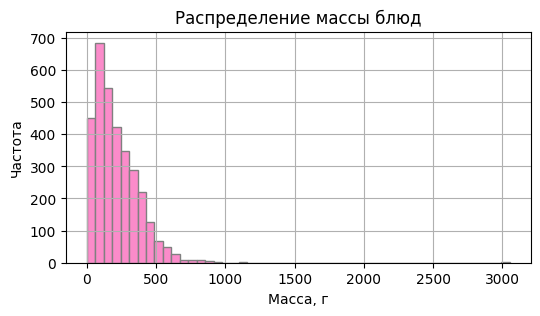

In [23]:
plt.figure(figsize=(6, 3))
plt.hist(dish_df['total_mass'], bins=50, color="#fb8bca", edgecolor='gray')
plt.title('Распределение массы блюд')
plt.xlabel('Масса, г')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

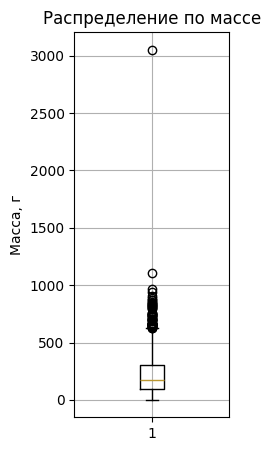

In [24]:
# Распределение по массе
plt.figure(figsize=(2, 5))
plt.boxplot(dish_df['total_mass'])
plt.title('Распределение по массе')
plt.ylabel('Масса, г')
plt.grid(True)
plt.show()

Посмотрим на распределение массы по train/test

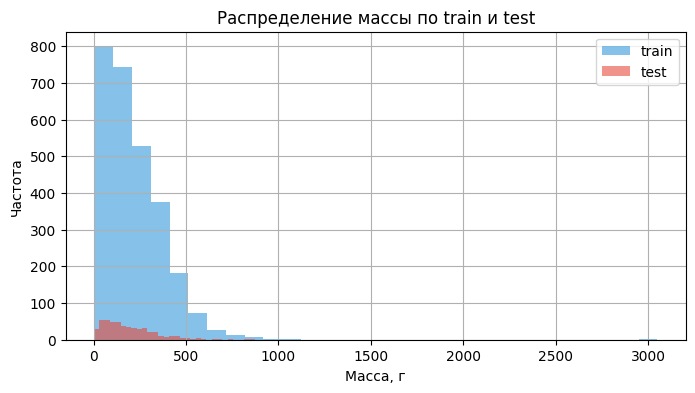

In [46]:
# train/test
train_cal = dish_df[dish_df['split'] == 'train']['total_mass']
test_cal = dish_df[dish_df['split'] == 'test']['total_mass']

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(train_cal, bins=30, alpha=0.6, label='train', color='#3498db')
ax.hist(test_cal, bins=30, alpha=0.6, label='test', color='#e74c3c')
ax.set_title('Распределение массы по train и test')
ax.set_xlabel('Масса, г')
ax.set_ylabel('Частота')
ax.legend()
ax.grid(True)

plt.show()

Данные распределены пропорционально.

Проверим, насколько калорийность зависит от массы блюда.

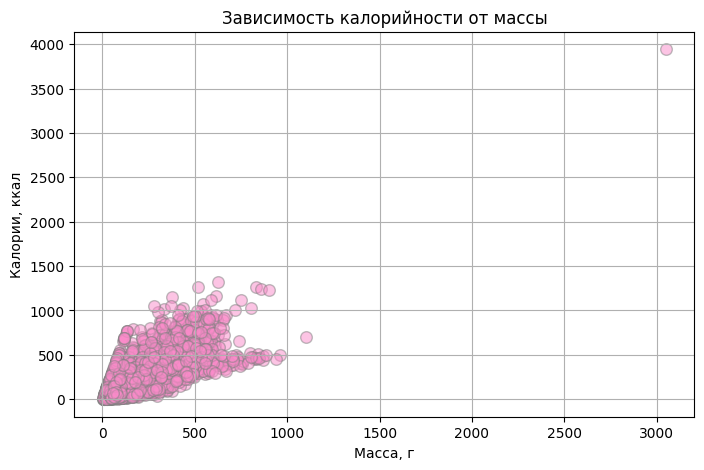

In [26]:
plt.figure(figsize=(8, 5))
plt.scatter(dish_df['total_mass'], dish_df['total_calories'],
            alpha=0.5, c='#fb8bca', edgecolor='grey', s=70)
plt.title('Зависимость калорийности от массы')
plt.xlabel('Масса, г')
plt.ylabel('Калории, ккал')
plt.grid(True)
plt.show()

In [27]:
# Корреляция
corr = round(dish_df[['total_mass', 'total_calories']].corr(), 2)
print(f'Корреляция между массой и калорийностью:')
print(corr)

Корреляция между массой и калорийностью:
                total_mass  total_calories
total_mass            1.00            0.76
total_calories        0.76            1.00


Корреляция между массой и калорийностью блюда - 0.76, что свидетельствует о высокой степени зависимости одного параметра от другого.

### Очистим данные

In [28]:
cal_threshold = 1500 # порог калорийности
mass_threshold = 1000 # порог массы

dish_df_cleaned = dish_df[
    (dish_df['total_calories'] <= cal_threshold) & 
    (dish_df['total_mass'] <= mass_threshold) &
    (dish_df['total_calories'] != 0) &
    (dish_df['total_mass'] != 0)
]

print(f"Оригинально блюд: {len(dish_df)}")
print(f"После удаления выбросов: {len(dish_df_cleaned)}")
print(f"Удалено: {len(dish_df) - len(dish_df_cleaned)} блюд(а)")

Оригинально блюд: 3262
После удаления выбросов: 3258
Удалено: 4 блюд(а)


In [29]:
# Удаляем фото
outliners_df = dish_df[
    (dish_df['total_calories'] > cal_threshold) | 
    (dish_df['total_mass'] > mass_threshold) |
    (dish_df['total_calories'] == 0) | 
    (dish_df['total_mass'] == 0) 

]

removed_ids = set(outliners_df['dish_id'])

# Удаляем папки
image_dir = "data/images"
deleted_count = 0

for dish_id in removed_ids:
    folder_path = os.path.join(image_dir, str(dish_id))
    if os.path.exists(folder_path):
        import shutil
        shutil.rmtree(folder_path)
        deleted_count += 1

print(f"Удалено папок с фото: {deleted_count}")

Удалено папок с фото: 2


### 1.8 Анализ ингредиентов

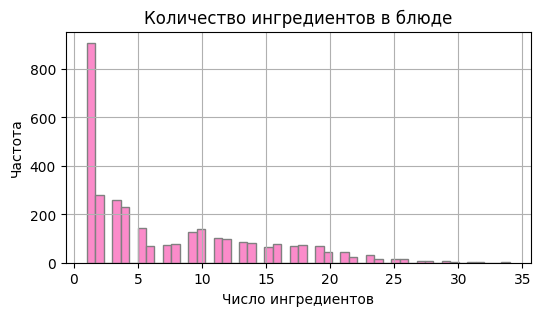

In [30]:
# Количество ингредиентов
dish_df_cleaned.loc[:, 'n_ingr'] = dish_df_cleaned['ingredients'].str.count(';') + 1
plt.figure(figsize=(6,3))
plt.hist(dish_df_cleaned['n_ingr'], bins=50, color='#fb8bca', edgecolor='grey')
plt.title("Количество ингредиентов в блюде")
plt.xlabel("Число ингредиентов")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

In [31]:
round(dish_df_cleaned['n_ingr'].describe(), 2)

count    3258.00
mean        7.31
std         6.94
min         1.00
25%         1.00
50%         4.00
75%        12.00
max        34.00
Name: n_ingr, dtype: float64

Максимальное количество ингредиентов в блюде - 34, минимальное - 1.

Посмотрим, как связаны калорийность блюда и количество ингредиентов

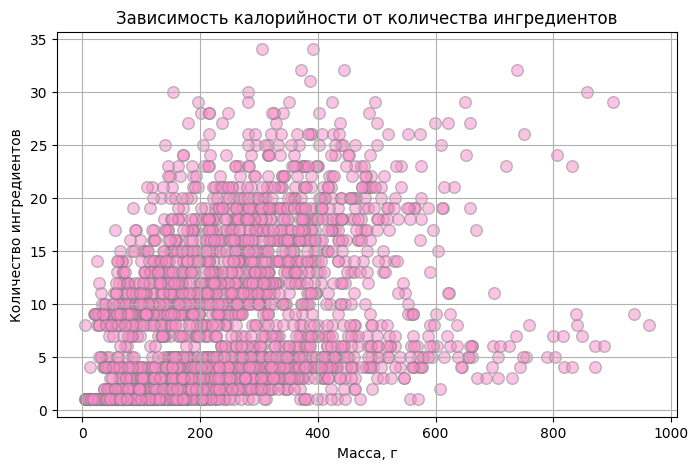

In [32]:
plt.figure(figsize=(8, 5))
plt.scatter(dish_df_cleaned['total_mass'], dish_df_cleaned['n_ingr'],
            alpha=0.5, c='#fb8bca', edgecolor='grey', s=70)
plt.title('Зависимость калорийности от количества ингредиентов')
plt.xlabel('Масса, г')
plt.ylabel('Количество ингредиентов')
plt.grid(True)
plt.show()

Посмотрим, как связаны масса блюда и количество ингредиентов

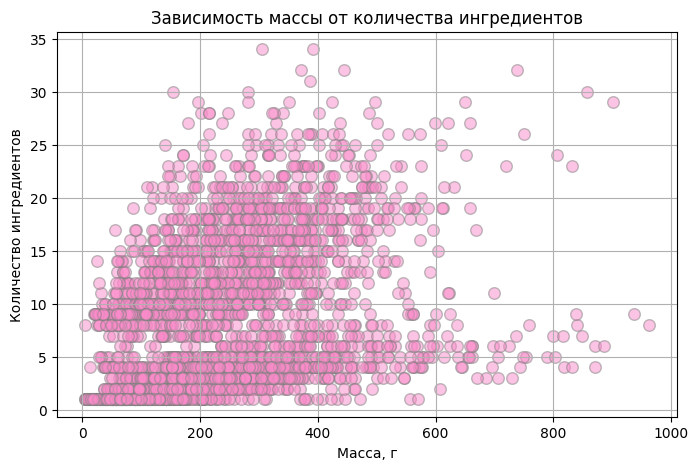

In [33]:
plt.figure(figsize=(8, 5))
plt.scatter(dish_df_cleaned['total_mass'], dish_df_cleaned['n_ingr'],
            alpha=0.5, c='#fb8bca', edgecolor='grey', s=70)
plt.title('Зависимость массы от количества ингредиентов')
plt.xlabel('Масса, г')
plt.ylabel('Количество ингредиентов')
plt.grid(True)
plt.show()

In [34]:
# Корреляция
columns_for_corr = ['total_calories', 'total_mass', 'n_ingr']
correlation_matrix = round(dish_df_cleaned[columns_for_corr].corr(),2)

print('Матрица корреляции:')
print(correlation_matrix)

Матрица корреляции:
                total_calories  total_mass  n_ingr
total_calories            1.00        0.74    0.49
total_mass                0.74        1.00    0.47
n_ingr                    0.49        0.47    1.00


наибольшая взаимосвязь наблюдается у калорийности и массы, однако между количеством ингредиентов и калорийностью и массой также есть корреляция - 0.47 с массой, 0.49 с калорийностью => чем больше ингредиентов, тем выше калорийность и масса

### Выводы по EDA

#### Стратегия решения задачи

##### Архитектура модели
- Используется **мультимодальная нейросеть**, объединяющая визуальные и табличные данные.
- **CNN (EfficientNet-B0)** для извлечения признаков из изображений.
- **MLP** для обработки табличных данных (ингредиенты и масса).
- **Fusion module** объединяет признаки из обеих модальностей для финального предсказания.

##### Предварительная обработка и аугментации
- Горизонтальные и вертикальные отражения изображений.
- Случайные повороты и вращения.
- Коррекция яркости, контраста и насыщенности.
- Случайное размытие изображений для повышения устойчивости модели.

##### Процесс обучения
- Основная **метрика качества**: MAE (цель — <50).
- **Функция потерь**: L1 Loss.
- **Оптимизация**: Transfer learning с EfficientNet-B0, Adam с weight decay.
- **Регулировка обучения**: ReduceLROnPlateau и Early stopping на основе MAE на валидации.


## 2. Запуск обучения модели


In [35]:
# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Доступная память: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Используемое устройство: cuda
GPU: Tesla T4
Доступная память: 15.66 GB


### 2.1 Запуск обучения


In [36]:
history, best_mae = train()

Начало обучения
Устройство: cuda
Загрузка данных
Train dataset size: 2755
Test dataset size: 507
Количество ингредиентов: 555
Создание модели
Всего параметров: 5,346,045
Обучаемых параметров: 5,346,045
Начало обучения на 50 эпох...

Эпоха 1/50


Training:   9%|▉         | 8/87 [00:03<00:16,  4.88it/s, loss=249.75]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  68%|██████▊   | 59/87 [00:12<00:05,  5.19it/s, loss=180.44]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  70%|███████   | 61/87 [00:13<00:05,  4.96it/s, loss=156.69]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.53it/s, loss=106.81, mae=106.81]


Train Loss: 210.2497
Val Loss: 159.5238
Val MAE: 159.5238
Сохранена лучшая модель (MAE: 159.5238)

Эпоха 2/50


Training:   5%|▍         | 4/87 [00:01<00:21,  3.80it/s, loss=124.11]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  16%|█▌        | 14/87 [00:03<00:13,  5.26it/s, loss=114.77]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  97%|█████████▋| 84/87 [00:16<00:00,  5.96it/s, loss=82.87] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.63it/s, loss=109.85, mae=109.85]


Train Loss: 103.8007
Val Loss: 188.1286
Val MAE: 188.1286

Эпоха 3/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  14%|█▍        | 12/87 [00:02<00:13,  5.58it/s, loss=100.46]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  68%|██████▊   | 59/87 [00:12<00:05,  5.43it/s, loss=77.57] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.54it/s, loss=73.76, mae=73.76]  


Train Loss: 85.7526
Val Loss: 127.7955
Val MAE: 127.7955
Сохранена лучшая модель (MAE: 127.7955)

Эпоха 4/50


Training:   8%|▊         | 7/87 [00:01<00:15,  5.02it/s, loss=53.64] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  38%|███▊      | 33/87 [00:06<00:09,  5.88it/s, loss=122.16]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  41%|████▏     | 36/87 [00:07<00:09,  5.18it/s, loss=77.53] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.60it/s, loss=63.23, mae=63.23]  


Train Loss: 80.5724
Val Loss: 105.3631
Val MAE: 105.3631
Сохранена лучшая модель (MAE: 105.3631)

Эпоха 5/50


Training:  33%|███▎      | 29/87 [00:06<00:12,  4.77it/s, loss=80.77] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  46%|████▌     | 40/87 [00:08<00:08,  5.42it/s, loss=58.78] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  52%|█████▏    | 45/87 [00:09<00:10,  4.16it/s, loss=79.45] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s, loss=59.13, mae=59.13]  


Train Loss: 78.1436
Val Loss: 112.8480
Val MAE: 112.8480

Эпоха 6/50


Training:  11%|█▏        | 10/87 [00:02<00:14,  5.25it/s, loss=72.73]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'

Training:  13%|█▎        | 11/87 [00:02<00:13,  5.61it/s, loss=72.73]

Training:  23%|██▎       | 20/87 [00:04<00:11,  5.83it/s, loss=91.64] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  77%|███████▋  | 67/87 [00:13<00:04,  4.86it/s, loss=79.50] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s, loss=57.63, mae=57.63] 


Train Loss: 74.6507
Val Loss: 106.6954
Val MAE: 106.6954

Эпоха 7/50


Training:  46%|████▌     | 40/87 [00:08<00:08,  5.82it/s, loss=63.75] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  74%|███████▎  | 64/87 [00:13<00:04,  5.62it/s, loss=72.91] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  83%|████████▎ | 72/87 [00:14<00:02,  6.18it/s, loss=117.60]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.51it/s, loss=45.72, mae=45.72] 


Train Loss: 72.2682
Val Loss: 86.8268
Val MAE: 86.8268
Сохранена лучшая модель (MAE: 86.8268)

Эпоха 8/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  24%|██▍       | 21/87 [00:04<00:12,  5.08it/s, loss=75.77] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  57%|█████▋    | 50/87 [00:10<00:07,  4.87it/s, loss=112.81]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s, loss=64.62, mae=64.62]  


Train Loss: 72.9980
Val Loss: 132.8493
Val MAE: 132.8493

Эпоха 9/50


Training:   2%|▏         | 2/87 [00:01<00:40,  2.09it/s, loss=63.05]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'

Training:   3%|▎         | 3/87 [00:01<00:27,  3.06it/s, loss=59.82]

Training:  38%|███▊      | 33/87 [00:07<00:12,  4.32it/s, loss=91.16] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  74%|███████▎  | 64/87 [00:12<00:03,  6.30it/s, loss=58.97] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s, loss=44.10, mae=44.10] 


Train Loss: 70.7757
Val Loss: 87.1511
Val MAE: 87.1511

Эпоха 10/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  23%|██▎       | 20/87 [00:04<00:11,  5.85it/s, loss=101.56]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  64%|██████▍   | 56/87 [00:11<00:05,  5.63it/s, loss=63.69] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.69it/s, loss=41.90, mae=41.90] 


Train Loss: 70.7246
Val Loss: 87.3329
Val MAE: 87.3329

Эпоха 11/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  24%|██▍       | 21/87 [00:04<00:12,  5.18it/s, loss=87.71]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  80%|████████  | 70/87 [00:14<00:03,  5.21it/s, loss=70.62] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'

Training:  82%|████████▏ | 71/87 [00:14<00:02,  5.62it/s, loss=45.05]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s, loss=36.22, mae=36.22] 


Train Loss: 68.5622
Val Loss: 76.0116
Val MAE: 76.0116
Сохранена лучшая модель (MAE: 76.0116)

Эпоха 12/50


Training:  47%|████▋     | 41/87 [00:08<00:10,  4.47it/s, loss=75.31] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  56%|█████▋    | 49/87 [00:10<00:07,  4.93it/s, loss=83.45]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  68%|██████▊   | 59/87 [00:12<00:05,  5.47it/s, loss=91.42] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s, loss=48.11, mae=48.11] 


Train Loss: 69.7888
Val Loss: 82.5614
Val MAE: 82.5614

Эпоха 13/50


Training:  26%|██▋       | 23/87 [00:05<00:11,  5.38it/s, loss=86.77] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  39%|███▉      | 34/87 [00:07<00:10,  5.12it/s, loss=86.39]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  76%|███████▌  | 66/87 [00:13<00:04,  5.19it/s, loss=78.82]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.42it/s, loss=37.62, mae=37.62] 


Train Loss: 67.4403
Val Loss: 89.2554
Val MAE: 89.2554

Эпоха 14/50


Training:  15%|█▍        | 13/87 [00:03<00:15,  4.88it/s, loss=54.80]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  21%|██        | 18/87 [00:04<00:13,  4.95it/s, loss=189.20]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  28%|██▊       | 24/87 [00:05<00:11,  5.67it/s, loss=92.28] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.54it/s, loss=41.83, mae=41.83] 


Train Loss: 67.3966
Val Loss: 76.5960
Val MAE: 76.5960

Эпоха 15/50


Training:  20%|█▉        | 17/87 [00:03<00:15,  4.56it/s, loss=83.62]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  33%|███▎      | 29/87 [00:06<00:12,  4.56it/s, loss=59.05] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  72%|███████▏  | 63/87 [00:13<00:04,  5.07it/s, loss=50.26] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s, loss=40.67, mae=40.67] 


Train Loss: 68.8347
Val Loss: 75.9059
Val MAE: 75.9059
Сохранена лучшая модель (MAE: 75.9059)

Эпоха 16/50


Training:  64%|██████▍   | 56/87 [00:11<00:05,  5.68it/s, loss=50.97] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  66%|██████▌   | 57/87 [00:12<00:07,  4.04it/s, loss=55.17]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  71%|███████▏  | 62/87 [00:12<00:04,  5.26it/s, loss=63.53]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s, loss=42.23, mae=42.23] 


Train Loss: 69.2267
Val Loss: 65.6548
Val MAE: 65.6548
Сохранена лучшая модель (MAE: 65.6548)

Эпоха 17/50


Training:  48%|████▊     | 42/87 [00:08<00:09,  4.64it/s, loss=76.65]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  66%|██████▌   | 57/87 [00:11<00:06,  4.72it/s, loss=57.99]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  87%|████████▋ | 76/87 [00:15<00:02,  4.13it/s, loss=55.45] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s, loss=43.19, mae=43.19] 


Train Loss: 65.8316
Val Loss: 89.4051
Val MAE: 89.4051

Эпоха 18/50


Training:   1%|          | 1/87 [00:00<01:20,  1.07it/s, loss=63.39]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  40%|████      | 35/87 [00:07<00:10,  4.76it/s, loss=55.48]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  87%|████████▋ | 76/87 [00:15<00:01,  5.55it/s, loss=53.17] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.49it/s, loss=33.17, mae=33.17] 


Train Loss: 64.6307
Val Loss: 85.8220
Val MAE: 85.8220

Эпоха 19/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  69%|██████▉   | 60/87 [00:12<00:04,  5.52it/s, loss=89.68]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  72%|███████▏  | 63/87 [00:13<00:04,  5.40it/s, loss=61.70]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s, loss=34.09, mae=34.09] 


Train Loss: 64.2666
Val Loss: 58.6114
Val MAE: 58.6114
Сохранена лучшая модель (MAE: 58.6114)

Эпоха 20/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:   6%|▌         | 5/87 [00:01<00:21,  3.75it/s, loss=66.39]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  52%|█████▏    | 45/87 [00:09<00:07,  5.47it/s, loss=69.77] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.54it/s, loss=35.88, mae=35.88]


Train Loss: 64.5027
Val Loss: 54.7017
Val MAE: 54.7017
Сохранена лучшая модель (MAE: 54.7017)

Эпоха 21/50


Training:   5%|▍         | 4/87 [00:01<00:21,  3.86it/s, loss=78.42]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  49%|████▉     | 43/87 [00:08<00:08,  5.36it/s, loss=66.85]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  55%|█████▌    | 48/87 [00:09<00:07,  5.25it/s, loss=120.64]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'

Training:  56%|█████▋    | 49/87 [00:10<00:07,  4.95it/s, loss=63.10] 

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.51it/s, loss=58.29, mae=58.29]  


Train Loss: 62.6775
Val Loss: 116.7025
Val MAE: 116.7025

Эпоха 22/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  25%|██▌       | 22/87 [00:05<00:12,  5.06it/s, loss=70.03]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  26%|██▋       | 23/87 [00:05<00:11,  5.44it/s, loss=61.00]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s, loss=34.48, mae=34.48] 


Train Loss: 64.2516
Val Loss: 69.4416
Val MAE: 69.4416

Эпоха 23/50


Training:  47%|████▋     | 41/87 [00:08<00:08,  5.72it/s, loss=101.10]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  83%|████████▎ | 72/87 [00:14<00:02,  5.65it/s, loss=44.92] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  92%|█████████▏| 80/87 [00:16<00:01,  5.92it/s, loss=64.47]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.62it/s, loss=40.09, mae=40.09] 


Train Loss: 63.8755
Val Loss: 70.8861
Val MAE: 70.8861

Эпоха 24/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:   9%|▉         | 8/87 [00:02<00:14,  5.29it/s, loss=63.27] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  51%|█████     | 44/87 [00:09<00:07,  5.90it/s, loss=71.42] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.56it/s, loss=46.62, mae=46.62] 


Train Loss: 65.4497
Val Loss: 88.5306
Val MAE: 88.5306

Эпоха 25/50


Training:  13%|█▎        | 11/87 [00:02<00:13,  5.50it/s, loss=52.28]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'

Training:  14%|█▍        | 12/87 [00:02<00:12,  5.84it/s, loss=89.08]

Training:  52%|█████▏    | 45/87 [00:09<00:08,  4.88it/s, loss=48.75]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  61%|██████    | 53/87 [00:11<00:08,  4.16it/s, loss=61.97] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'

Training:  62%|██████▏   | 54/87 [00:11<00:07,  4.71it/s, loss=49.45]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s, loss=34.36, mae=34.36] 


Train Loss: 64.6332
Val Loss: 59.4713
Val MAE: 59.4713

Эпоха 26/50


Training:  28%|██▊       | 24/87 [00:05<00:11,  5.51it/s, loss=67.27]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  49%|████▉     | 43/87 [00:09<00:08,  5.19it/s, loss=51.67]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  87%|████████▋ | 76/87 [00:15<00:01,  5.86it/s, loss=51.73]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.63it/s, loss=40.87, mae=40.87] 


Train Loss: 59.0227
Val Loss: 89.1930
Val MAE: 89.1930

Эпоха 27/50


Training:  25%|██▌       | 22/87 [00:05<00:12,  5.32it/s, loss=53.02]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'

Training:  26%|██▋       | 23/87 [00:05<00:11,  5.64it/s, loss=44.28]

Training:  54%|█████▍    | 47/87 [00:09<00:07,  5.40it/s, loss=44.92] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  83%|████████▎ | 72/87 [00:14<00:02,  6.15it/s, loss=69.80] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.64it/s, loss=33.65, mae=33.65] 


Train Loss: 61.2506
Val Loss: 78.3966
Val MAE: 78.3966

Эпоха 28/50


Training:  20%|█▉        | 17/87 [00:04<00:15,  4.60it/s, loss=35.74]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  31%|███       | 27/87 [00:06<00:11,  5.38it/s, loss=50.17] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  34%|███▍      | 30/87 [00:06<00:11,  5.10it/s, loss=47.26]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.63it/s, loss=28.95, mae=28.95] 


Train Loss: 60.0493
Val Loss: 58.0904
Val MAE: 58.0904

Эпоха 29/50


Training:  39%|███▉      | 34/87 [00:07<00:11,  4.52it/s, loss=60.52] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  51%|█████     | 44/87 [00:09<00:07,  5.81it/s, loss=48.22]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  77%|███████▋  | 67/87 [00:13<00:03,  5.46it/s, loss=66.72] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.67it/s, loss=36.50, mae=36.50]


Train Loss: 60.5133
Val Loss: 49.7355
Val MAE: 49.7355
Сохранена лучшая модель (MAE: 49.7355)

Эпоха 30/50


Training:  18%|█▊        | 16/87 [00:03<00:12,  5.75it/s, loss=55.24]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  82%|████████▏ | 71/87 [00:14<00:02,  5.96it/s, loss=52.81]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  86%|████████▌ | 75/87 [00:15<00:02,  5.32it/s, loss=57.99] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s, loss=20.59, mae=20.59] 


Train Loss: 56.8536
Val Loss: 55.4933
Val MAE: 55.4933

Эпоха 31/50


Training:  33%|███▎      | 29/87 [00:06<00:13,  4.37it/s, loss=67.06] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  47%|████▋     | 41/87 [00:08<00:08,  5.67it/s, loss=42.02]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  78%|███████▊  | 68/87 [00:13<00:03,  5.55it/s, loss=47.45] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s, loss=29.86, mae=29.86]


Train Loss: 57.1494
Val Loss: 48.0643
Val MAE: 48.0643
Сохранена лучшая модель (MAE: 48.0643)

Эпоха 32/50


Training:   3%|▎         | 3/87 [00:01<00:28,  2.96it/s, loss=68.07]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  28%|██▊       | 24/87 [00:05<00:11,  5.70it/s, loss=43.59] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  60%|█████▉    | 52/87 [00:10<00:06,  5.50it/s, loss=47.81]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.66it/s, loss=28.62, mae=28.62]


Train Loss: 57.4386
Val Loss: 52.6346
Val MAE: 52.6346

Эпоха 33/50


Training:  38%|███▊      | 33/87 [00:07<00:09,  5.45it/s, loss=45.40] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'

Training:  39%|███▉      | 34/87 [00:07<00:11,  4.42it/s, loss=41.16]

Training:  54%|█████▍    | 47/87 [00:09<00:08,  4.95it/s, loss=39.37]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  94%|█████████▍| 82/87 [00:16<00:00,  5.25it/s, loss=53.81]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.62it/s, loss=28.40, mae=28.40] 


Train Loss: 54.6290
Val Loss: 73.1584
Val MAE: 73.1584

Эпоха 34/50


Training:  46%|████▌     | 40/87 [00:08<00:08,  5.36it/s, loss=47.82]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  56%|█████▋    | 49/87 [00:09<00:06,  5.68it/s, loss=62.79]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  64%|██████▍   | 56/87 [00:11<00:06,  5.04it/s, loss=59.21]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.76it/s, loss=27.75, mae=27.75] 


Train Loss: 55.5923
Val Loss: 61.7521
Val MAE: 61.7521

Эпоха 35/50


Training:   1%|          | 1/87 [00:00<01:25,  1.01it/s, loss=71.55]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  37%|███▋      | 32/87 [00:06<00:09,  5.84it/s, loss=57.60] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  85%|████████▌ | 74/87 [00:15<00:03,  4.32it/s, loss=54.37] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.74it/s, loss=22.87, mae=22.87] 


Train Loss: 56.7438
Val Loss: 57.8935
Val MAE: 57.8935

Эпоха 36/50


Training:  28%|██▊       | 24/87 [00:05<00:11,  5.32it/s, loss=54.47]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  37%|███▋      | 32/87 [00:06<00:10,  5.41it/s, loss=41.18]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  86%|████████▌ | 75/87 [00:15<00:02,  4.63it/s, loss=45.50] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.70it/s, loss=21.76, mae=21.76]


Train Loss: 54.5731
Val Loss: 48.2669
Val MAE: 48.2669

Эпоха 37/50


Training:  23%|██▎       | 20/87 [00:04<00:11,  5.97it/s, loss=38.83]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  56%|█████▋    | 49/87 [00:10<00:09,  3.96it/s, loss=45.70]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  67%|██████▋   | 58/87 [00:12<00:06,  4.61it/s, loss=71.38]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.72it/s, loss=24.18, mae=24.18]


Train Loss: 54.5975
Val Loss: 50.3953
Val MAE: 50.3953

Эпоха 38/50


Training:   6%|▌         | 5/87 [00:01<00:22,  3.57it/s, loss=28.01]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  14%|█▍        | 12/87 [00:02<00:13,  5.56it/s, loss=52.28]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  63%|██████▎   | 55/87 [00:11<00:07,  4.20it/s, loss=37.72] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.67it/s, loss=31.32, mae=31.32]


Train Loss: 52.6407
Val Loss: 42.4082
Val MAE: 42.4082
Сохранена лучшая модель (MAE: 42.4082)

Эпоха 39/50


Training:   5%|▍         | 4/87 [00:01<00:21,  3.90it/s, loss=40.98]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:   8%|▊         | 7/87 [00:02<00:17,  4.56it/s, loss=48.74] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  87%|████████▋ | 76/87 [00:15<00:01,  5.63it/s, loss=40.36] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.68it/s, loss=29.00, mae=29.00]


Train Loss: 53.4389
Val Loss: 46.6578
Val MAE: 46.6578

Эпоха 40/50


Training:   0%|          | 0/87 [00:00<?, ?it/s]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  30%|██▉       | 26/87 [00:05<00:10,  5.57it/s, loss=66.43] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  51%|█████     | 44/87 [00:09<00:08,  4.78it/s, loss=43.79] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'

Training:  52%|█████▏    | 45/87 [00:09<00:08,  5.25it/s, loss=43.79]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.62it/s, loss=26.64, mae=26.64]


Train Loss: 55.5206
Val Loss: 43.7283
Val MAE: 43.7283

Эпоха 41/50


Training:  10%|█         | 9/87 [00:02<00:18,  4.24it/s, loss=40.44]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'

Training:  11%|█▏        | 10/87 [00:02<00:16,  4.81it/s, loss=51.80]


Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'

Training:  11%|█▏        | 10/87 [00:02<00:16,  4.81it/s, loss=77.93]

Training:  89%|████████▊ | 77/87 [00:15<00:01,  5.91it/s, loss=49.81] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s, loss=24.88, mae=24.88]


Train Loss: 52.3779
Val Loss: 50.0540
Val MAE: 50.0540

Эпоха 42/50


Training:  52%|█████▏    | 45/87 [00:09<00:07,  5.66it/s, loss=71.96] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  70%|███████   | 61/87 [00:12<00:04,  5.57it/s, loss=59.11]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'
Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.67it/s, loss=29.95, mae=29.95] 


Train Loss: 54.5057
Val Loss: 56.4162
Val MAE: 56.4162

Эпоха 43/50


Training:   9%|▉         | 8/87 [00:02<00:13,  5.65it/s, loss=58.40]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  28%|██▊       | 24/87 [00:05<00:11,  5.62it/s, loss=36.31] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  52%|█████▏    | 45/87 [00:09<00:10,  4.10it/s, loss=61.34]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s, loss=28.20, mae=28.20]


Train Loss: 53.9239
Val Loss: 42.1253
Val MAE: 42.1253
Сохранена лучшая модель (MAE: 42.1253)

Эпоха 44/50


Training:  18%|█▊        | 16/87 [00:03<00:13,  5.33it/s, loss=51.54]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  57%|█████▋    | 50/87 [00:10<00:07,  4.90it/s, loss=58.85]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  66%|██████▌   | 57/87 [00:12<00:07,  4.10it/s, loss=105.83]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.64it/s, loss=26.43, mae=26.43]


Train Loss: 54.0962
Val Loss: 48.2410
Val MAE: 48.2410

Эпоха 45/50


Training:  29%|██▊       | 25/87 [00:05<00:13,  4.53it/s, loss=63.58]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  47%|████▋     | 41/87 [00:08<00:10,  4.41it/s, loss=39.65] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  74%|███████▎  | 64/87 [00:13<00:03,  5.81it/s, loss=35.63]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'

Training:  75%|███████▍  | 65/87 [00:13<00:05,  4.24it/s, loss=43.22]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.53it/s, loss=26.77, mae=26.77]


Train Loss: 53.2129
Val Loss: 47.8109
Val MAE: 47.8109

Эпоха 46/50


Training:   3%|▎         | 3/87 [00:01<00:27,  3.03it/s, loss=42.91]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  56%|█████▋    | 49/87 [00:10<00:06,  5.61it/s, loss=65.14] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  92%|█████████▏| 80/87 [00:16<00:01,  4.98it/s, loss=44.95]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s, loss=29.13, mae=29.13] 


Train Loss: 52.3133
Val Loss: 58.1923
Val MAE: 58.1923

Эпоха 47/50


Training:   9%|▉         | 8/87 [00:02<00:14,  5.47it/s, loss=56.95]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  57%|█████▋    | 50/87 [00:10<00:07,  5.28it/s, loss=43.28]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  67%|██████▋   | 58/87 [00:11<00:06,  4.62it/s, loss=47.70] 

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s, loss=26.99, mae=26.99]


Train Loss: 51.9015
Val Loss: 42.4120
Val MAE: 42.4120

Эпоха 48/50


Training:  67%|██████▋   | 58/87 [00:12<00:05,  5.29it/s, loss=54.06]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  78%|███████▊  | 68/87 [00:13<00:03,  5.71it/s, loss=26.34]

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  93%|█████████▎| 81/87 [00:16<00:01,  4.19it/s, loss=49.72]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.63it/s, loss=31.54, mae=31.54] 


Train Loss: 50.5514
Val Loss: 59.6427
Val MAE: 59.6427

Эпоха 49/50


Training:  18%|█▊        | 16/87 [00:03<00:12,  5.73it/s, loss=31.09]

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  64%|██████▍   | 56/87 [00:11<00:05,  5.73it/s, loss=57.09] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Training:  91%|█████████ | 79/87 [00:15<00:01,  5.35it/s, loss=52.46]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s, loss=32.24, mae=32.24]


Train Loss: 53.7294
Val Loss: 50.6903
Val MAE: 50.6903

Эпоха 50/50


Training:  13%|█▎        | 11/87 [00:02<00:15,  5.03it/s, loss=53.53]

Error loading image data/images/dish_1560974769/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1560974769/rgb.png'


Training:  74%|███████▎  | 64/87 [00:12<00:03,  6.09it/s, loss=59.54] 

Error loading image data/images/dish_1556575700/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1556575700/rgb.png'


Training:  83%|████████▎ | 72/87 [00:14<00:02,  5.48it/s, loss=45.63] 

Error loading image data/images/dish_1561739805/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1561739805/rgb.png'


Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s, loss=22.99, mae=22.99]

Train Loss: 51.7003
Val Loss: 48.1326
Val MAE: 48.1326

Обучение завершено
Лучший Val MAE: 42.1253


### 2.2 Визуализация процесса обучения


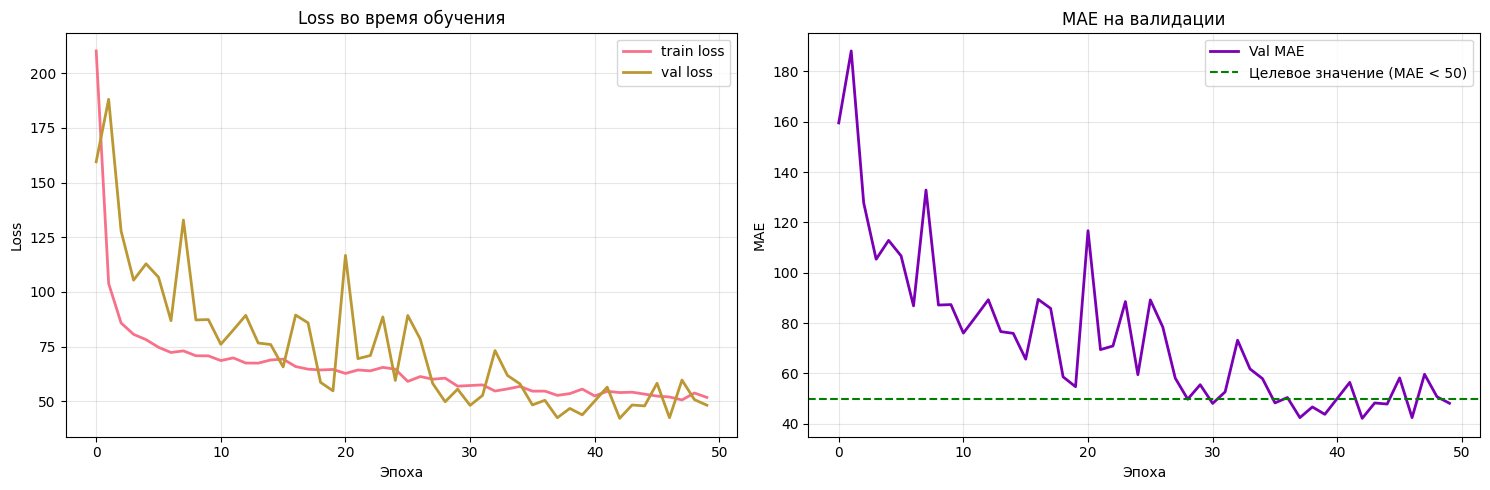

Лучший результат: Val MAE = 42.1253
Целевая метрика достигнута.


In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График loss
axes[0].plot(history['train_loss'], label='train loss', linewidth=2)
axes[0].plot(history['val_loss'], label='val loss', linewidth=2)
axes[0].set_title('Loss во время обучения')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График MAE
axes[1].plot(history['val_mae'], label='Val MAE', linewidth=2, color="#7b00b5")
axes[1].axhline(y=50, color='green', linestyle='--', label='Целевое значение (MAE < 50)')
axes[1].set_title('MAE на валидации')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Лучший результат: Val MAE = {best_mae:.4f}")
if best_mae < 50:
    print("Целевая метрика достигнута.")
else:
    print(f"Необходимо улучшение на {best_mae - 50:.2f}")


### Результаты
Модель обучена и сохранена как model_best.pth

## 3. Валидация качества модели


### 3.1 Загрузка обученной модели


In [38]:
num_ingredients = len(ingredients_df)

In [39]:
model = load_model('model_best.pth', num_ingredients, device)

Модель загружена из model_best.pth
Эпоха: 42
Val MAE: 42.1253


### 3.2 Инференс на тестовой выборке

In [40]:
_, test_loader, _ = create_dataloaders(
    dish_csv_path='data/dish.csv',
    ingredients_csv_path='data/ingredients.csv',
    img_dir='data/images',
    batch_size=32,
    num_workers=4
)

model.eval()
all_predictions = []
all_targets = []
all_errors = []

print("Запуск инференса на тестовой выборке")

with torch.no_grad():
    for batch in tqdm(test_loader):
        images = batch['image'].to(device)
        ingredients = batch['ingredients'].to(device)
        mass = batch['mass'].to(device)
        targets = batch['calories'].to(device)

        predictions = model(images, ingredients, mass)

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_errors.extend(np.abs(predictions.cpu().numpy() - targets.cpu().numpy()))

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_errors = np.array(all_errors)


Train dataset size: 2755
Test dataset size: 507
Запуск инференса на тестовой выборке


  0%|          | 0/16 [00:00<?, ?it/s]

Error loading image data/images/dish_1557861216/rgb.png: [Errno 2] No such file or directory: 'data/images/dish_1557861216/rgb.png'


100%|██████████| 16/16 [00:02<00:00,  5.52it/s]


### 3.3 Финальные метрики


In [41]:
mae = mean_absolute_error(all_targets, all_predictions)
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
r2 = r2_score(all_targets, all_predictions)

print("Финальные метрики на тестовой выборке")
print(f"MAE: {mae:.4f} кк")
print(f"RMSE: {rmse:.4f} кк")
print(f"R² Score: {r2:.4f}")

Финальные метрики на тестовой выборке
MAE: 42.1254 кк
RMSE: 74.5475 кк
R² Score: 0.8764


### 3.4 Визуализация предсказаний


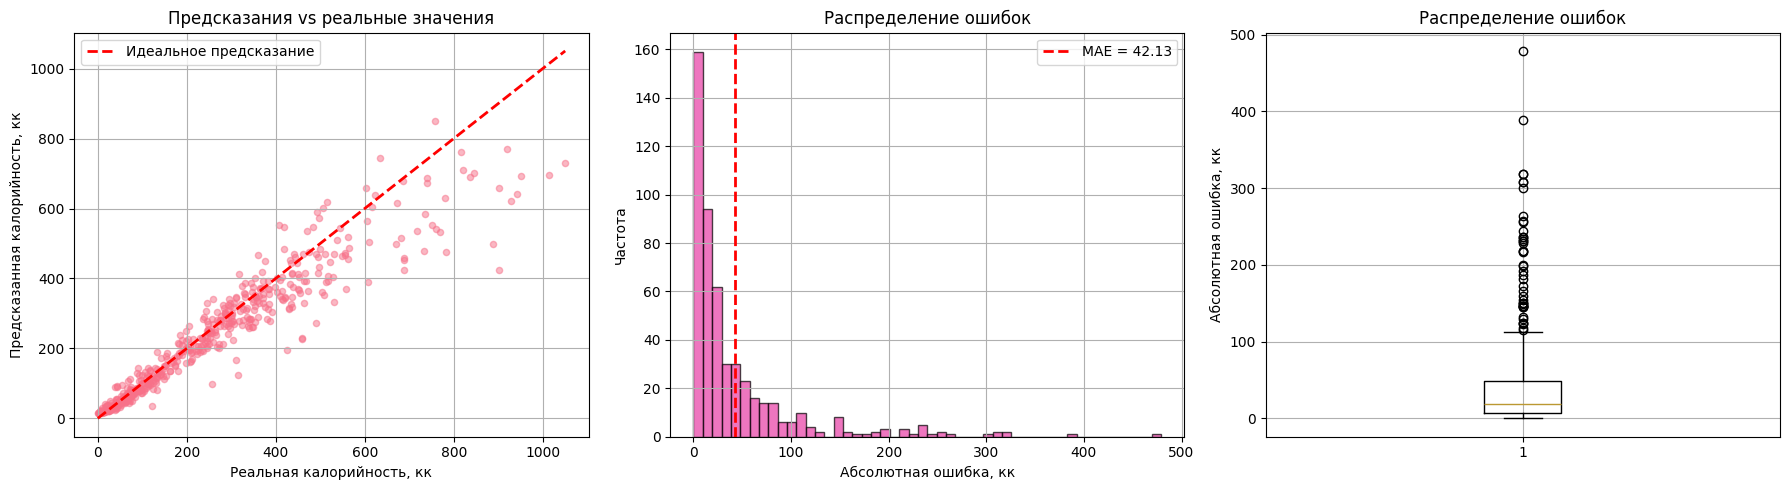

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Предсказания vs реальные значения
axes[0].scatter(all_targets, all_predictions, alpha=0.5, s=20)
axes[0].plot([all_targets.min(), all_targets.max()],
             [all_targets.min(), all_targets.max()],
             'r--', linewidth=2, label='Идеальное предсказание')
axes[0].set_xlabel('Реальная калорийность, кк')
axes[0].set_ylabel('Предсказанная калорийность, кк')
axes[0].set_title('Предсказания vs реальные значения')
axes[0].legend()
axes[0].grid(True)

# Ошибки
axes[1].hist(all_errors, bins=50, color="#e73ca5", edgecolor='black', alpha=0.7)
axes[1].axvline(x=mae, color='red', linestyle='--', linewidth=2, label=f'MAE = {mae:.2f}')
axes[1].set_xlabel('Абсолютная ошибка, кк')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].legend()
axes[1].grid(True)

# Статистика ошибок
axes[2].boxplot(all_errors, vert=True)
axes[2].set_ylabel('Абсолютная ошибка, кк')
axes[2].set_title('Распределение ошибок')
axes[2].grid(True)

plt.tight_layout()
plt.show()


### 3.5 Топ-5 самых сложных примеров


In [43]:
# Находим индексы с наибольшими ошибками
worst_indices = np.argsort(all_errors)[-5:][::-1]

print("ТОП-5 самых сложных примеров")

test_dish_df = dish_df_cleaned [dish_df_cleaned ['split'] == 'test'].reset_index(drop=True)

for rank, idx in enumerate(worst_indices, 1):
    real_cal = all_targets[idx]
    pred_cal = all_predictions[idx]
    error = all_errors[idx]

    dish_info = test_dish_df.iloc[idx]

    print(f"\n{rank}. Блюдо: {dish_info['dish_id']}")
    print(f"   Реальная калорийность: {real_cal:.2f} кк")
    print(f"   Предсказанная калорийность: {pred_cal:.2f} кк")
    print(f"   Абсолютная ошибка: {error:.2f} кк")
    print(f"   Масса блюда: {dish_info['total_mass']:.2f} г")

ТОП-5 самых сложных примеров

1. Блюдо: dish_1558641164
   Реальная калорийность: 902.20 кк
   Предсказанная калорийность: 423.32 кк
   Абсолютная ошибка: 478.88 кк
   Масса блюда: 154.00 г

2. Блюдо: dish_1558720236
   Реальная калорийность: 887.82 кк
   Предсказанная калорийность: 498.74 кк
   Абсолютная ошибка: 389.08 кк
   Масса блюда: 407.00 г

3. Блюдо: dish_1560975628
   Реальная калорийность: 1050.51 кк
   Предсказанная калорийность: 731.49 кк
   Абсолютная ошибка: 319.02 кк
   Масса блюда: 296.00 г

4. Блюдо: dish_1557862738
   Реальная калорийность: 1013.34 кк
   Предсказанная калорийность: 694.81 кк
   Абсолютная ошибка: 318.53 кк
   Масса блюда: 118.00 г

5. Блюдо: dish_1565974409
   Реальная калорийность: 927.81 кк
   Предсказанная калорийность: 620.16 кк
   Абсолютная ошибка: 307.65 кк
   Масса блюда: 228.00 г


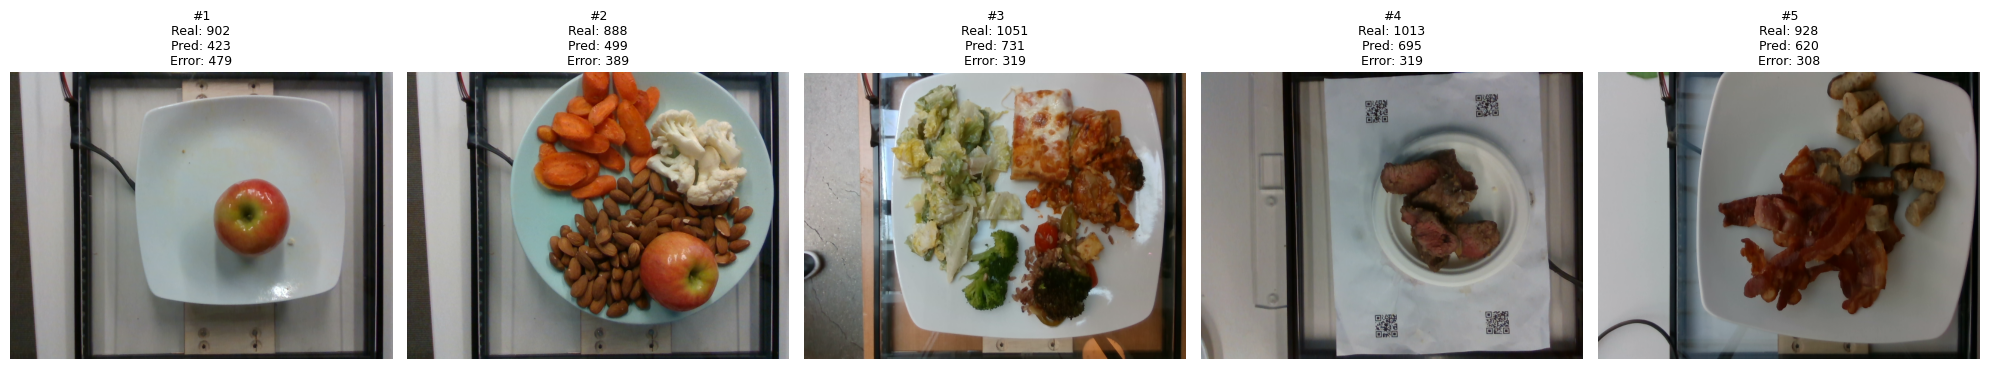

In [44]:
# Визуализация топ-5 сложных примеров
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(worst_indices):
    dish_info = test_dish_df.iloc[idx]
    dish_id = dish_info['dish_id']
    img_path = f'data/images/{dish_id}/rgb.png'

    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(
            f'#{i+1}\n'
            f'Real: {all_targets[idx]:.0f}\n'
            f'Pred: {all_predictions[idx]:.0f}\n'
            f'Error: {all_errors[idx]:.0f}',
            fontsize=9
        )
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'Нет\nизображения', ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## Заключение

Модель успешно обучена и протестирована.  

Результаты демонстрируют, что **мультимодальный подход**, объединяющий визуальные и табличные признаки, эффективно справляется с задачей предсказания калорийности блюд.  

Достигнутая точность **MAE = 42.13**, что соответствует целевому показателю **MAE < 50**, и позволяет считать модель готовой к интеграции в продукт.  

Были проанализированы **топ-5 самых сложных для модели примеров**. Возможные причины ошибок включают:

- Визуально похожие блюда с разной калорийностью.  
- Сложная композиция блюд с множеством компонентов.  
- Редкие комбинации ингредиентов.  
- Недостаточное представление некоторых ингредиентов в датасете.  
- Большое количество ингредиентов в одном блюде.  
- Выбросы по калорийности или массе.  
- Сложность оценки калорийности высокоэнергетических ингредиентов.
